Домашнее задание 2 NLP курс Иванов М.А.

In [2]:
import os
import json
import copy
import time
import torch
import torchvision
import torch.nn as nn
import numpy as np
from sklearn.metrics import f1_score
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

from tqdm import tqdm

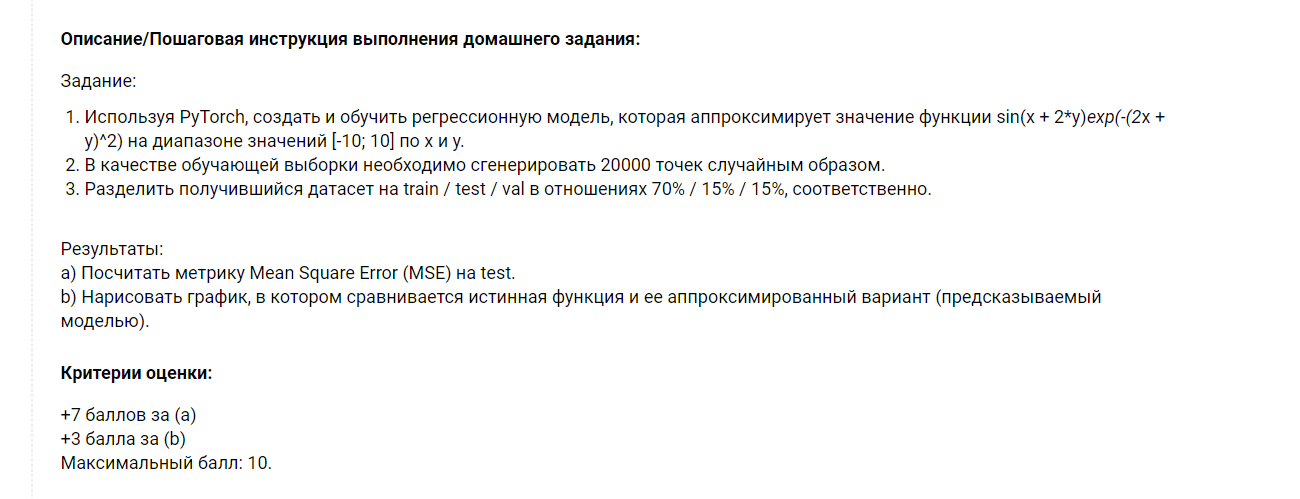

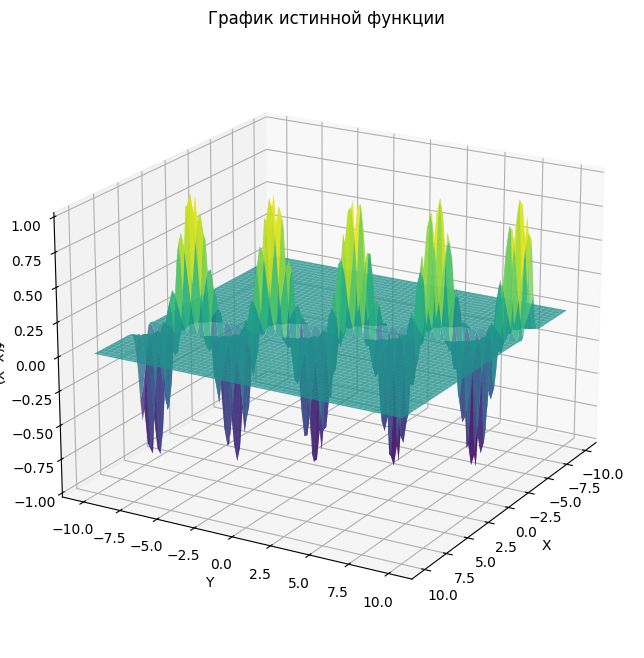

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Генерируем данные для 3D-графика
x_min, x_max, y_min, y_max = -10, 10, -10, 10
count = 100  # Количество точек для сетки
x = np.linspace(x_min, x_max, count)
y = np.linspace(y_min, y_max, count)
x_grid, y_grid = np.meshgrid(x, y)

z_grid = np.sin(x_grid + 2 * y_grid) * np.exp(-(2 * x_grid + y_grid) ** 2)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_grid, y_grid, z_grid, cmap="viridis", alpha=0.8)

ax.set_title("График истинной функции")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("f(X, Y)")
ax.view_init(elev=20., azim=30)
plt.show()


In [5]:
def data_func():
    # Создаём сетку значений x и y
    x = np.linspace(-10, 10, 200)
    y = np.linspace(-10, 10, 200)
    x_grid, y_grid = np.meshgrid(x, y)

    # Вычисляем значения функции
    z = np.sin(x_grid + 2 * y_grid) * np.exp(-(2 * x_grid + y_grid) ** 2)

    return x_grid, y_grid, z

x_grid, y_grid, z = data_func()

# Проверим размеры
print("Размеры x_grid:", x_grid.shape)
print("Размеры y_grid:", y_grid.shape)
print("Размеры z:", z.shape)


Размеры x_grid: (200, 200)
Размеры y_grid: (200, 200)
Размеры z: (200, 200)


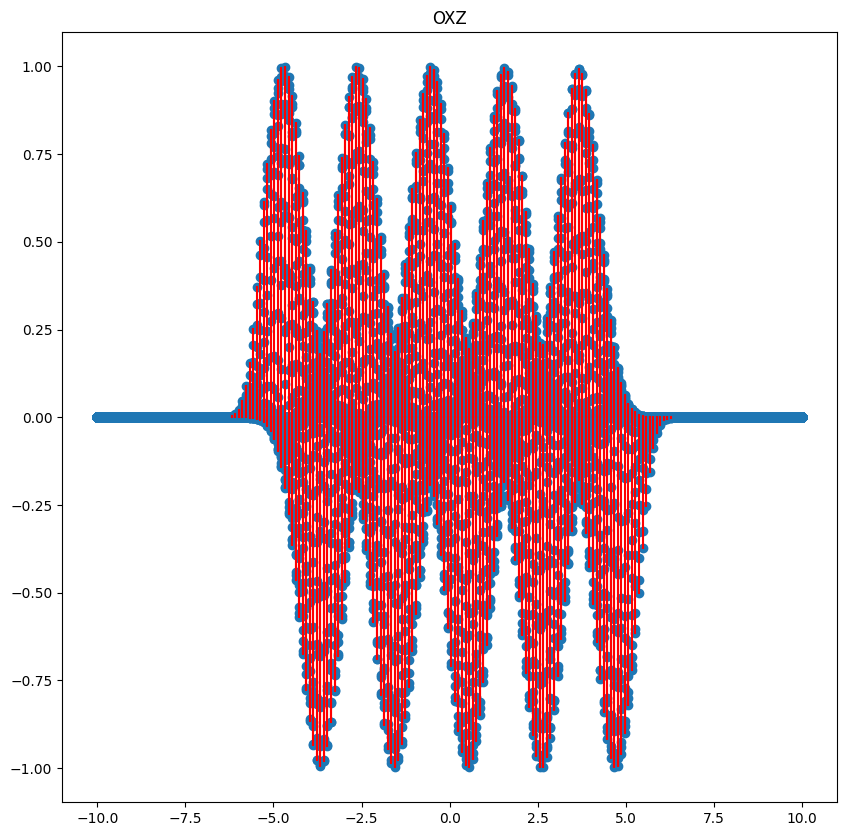

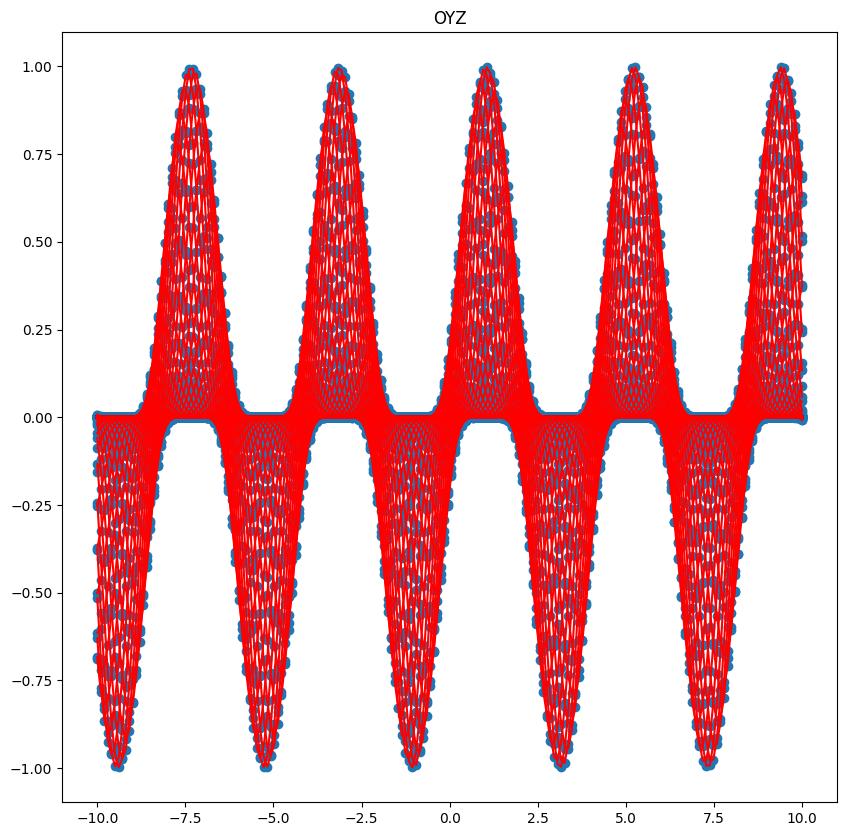

In [6]:

#Построим графики в разерезе чтоб посмотреть зависимости
plt.figure(figsize=(10, 10))
plt.scatter(x_grid, z)
plt.plot(x_grid, z, color='red', label="Линия")
plt.title("OXZ")
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(y_grid, z)
plt.plot(y_grid, z, color='red', label="Линия")
plt.title("OYZ")
plt.show()

In [7]:
#Для начала создаим свой датасет
class My_Func_dataset(Dataset):
    def __init__(self, x_min: int, x_max: int, y_min: int, y_max: int, count: int):
        self.x = np.random.uniform(x_min, x_max, count) #точки берем рандомно и вычисляем для них z
        self.y = np.random.uniform(y_min, y_max, count)
        self.z = np.sin(self.x + 2 * self.y) * np.exp(-(2 * self.x + self.y) ** 2)

    def __getitem__(self, index):
        x_data = self.x[index]
        y_data = self.y[index]
        z_data = self.z[index]
        return  torch.tensor([x_data, y_data], dtype=torch.float32), torch.tensor(z_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

Построим график который получится при генерации датасета

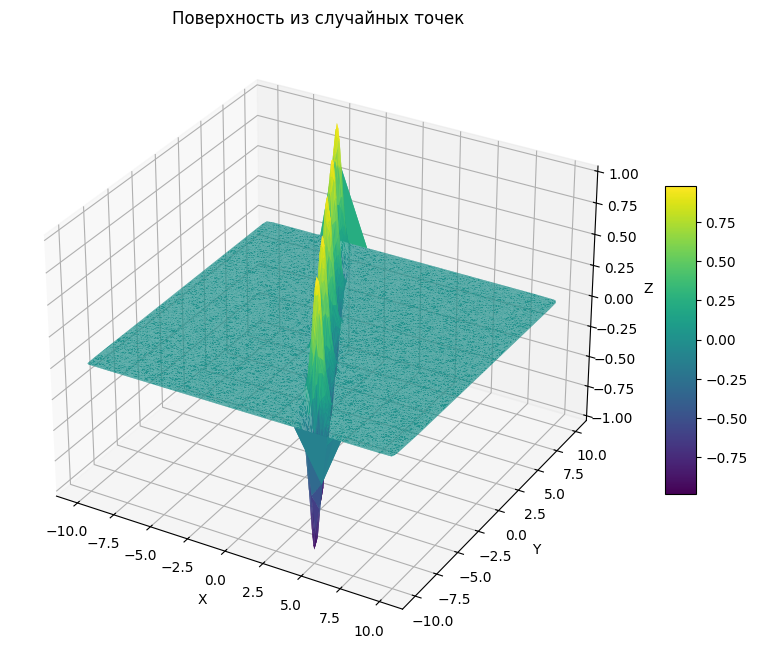

In [9]:
x = np.random.uniform(-10, 10, 20000)
y = np.random.uniform(-10, 10, 20000)
z = np.sin(x + 2 * y) * np.exp(-(2 * x + y) ** 2)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Поверхность из случайных точек")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()
# Показать график


График получился не совсем точным, но это связано с тем что при построении не было нормально распредленной сетки

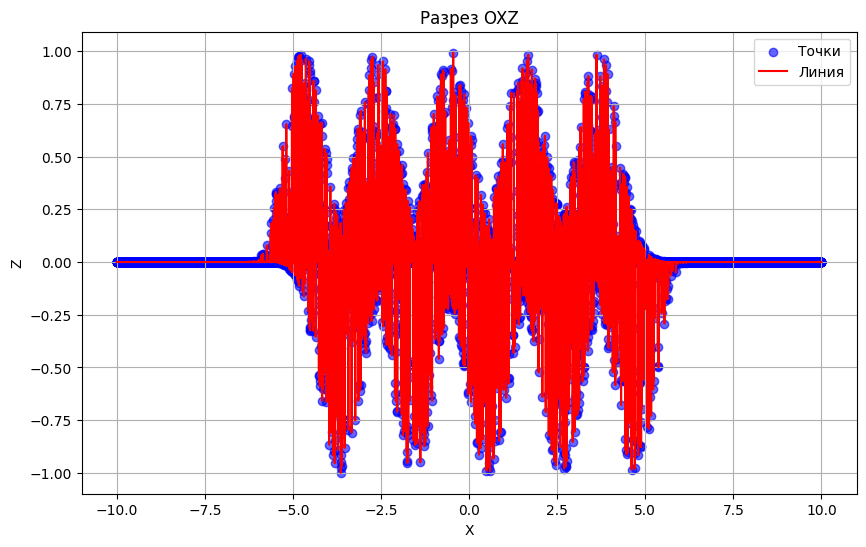

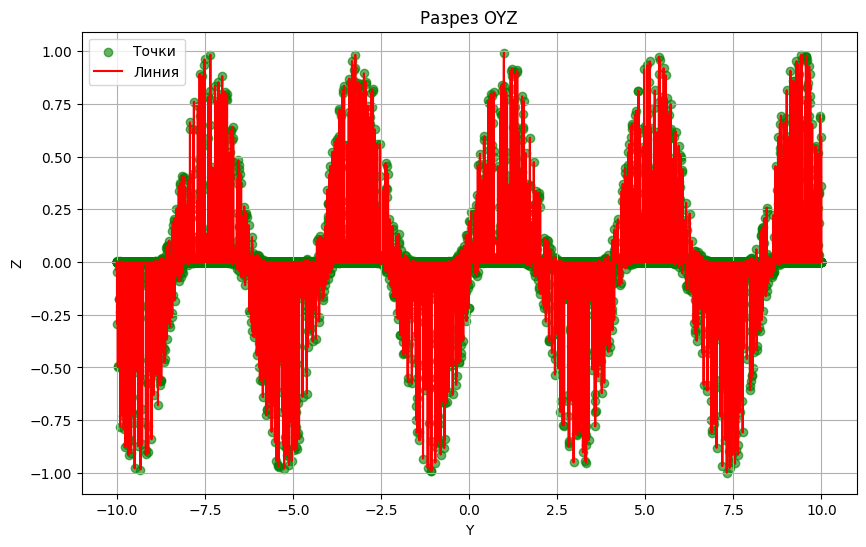

In [ ]:
# 1. График OXZ (фиксируем y около 0)
# посмотрим как наш график выглядит в разрезе у осей к  0
x_fixed_oxz = x
z_fixed_oxz = z

plt.figure(figsize=(10, 6))
plt.scatter(x_fixed_oxz, z_fixed_oxz, color='blue', alpha=0.6, label="Точки")
plt.plot(sorted(x_fixed_oxz), [z for _, z in sorted(zip(x_fixed_oxz, z_fixed_oxz))], color='red', label="Линия")
plt.title("Разрез OXZ")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()

y_fixed_oyz = y
z_fixed_oyz = z

plt.figure(figsize=(10, 6))
plt.scatter(y_fixed_oyz, z_fixed_oyz, color='green', alpha=0.6, label="Точки")
plt.plot(sorted(y_fixed_oyz), [z for _, z in sorted(zip(y_fixed_oyz, z_fixed_oyz))], color='red', label="Линия")
plt.title("Разрез OYZ")
plt.xlabel("Y")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()

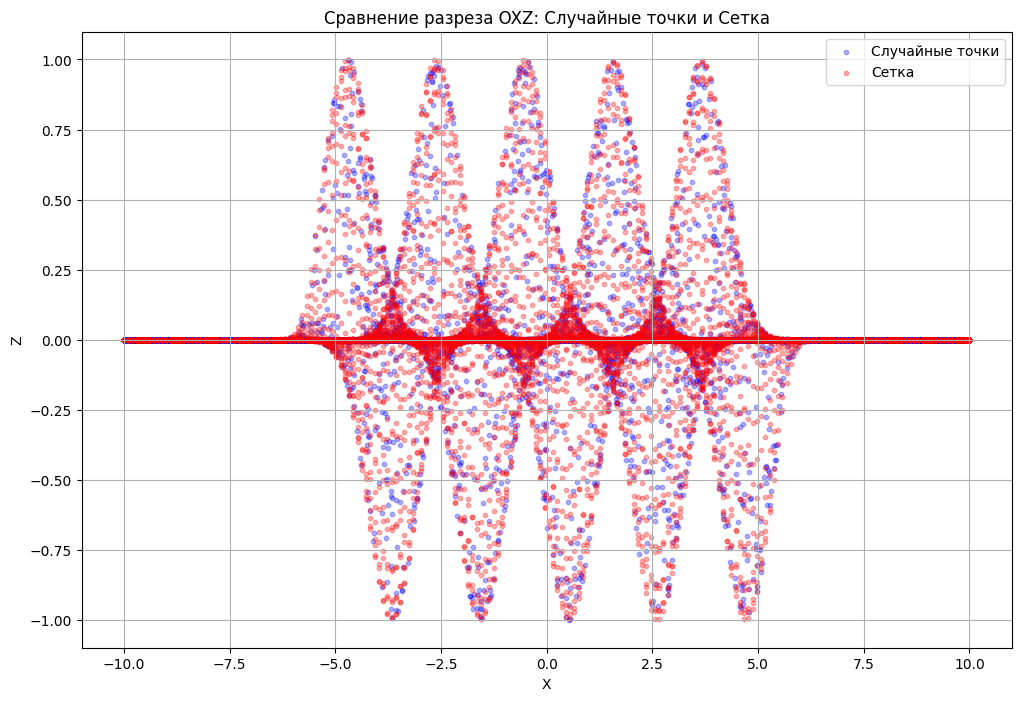

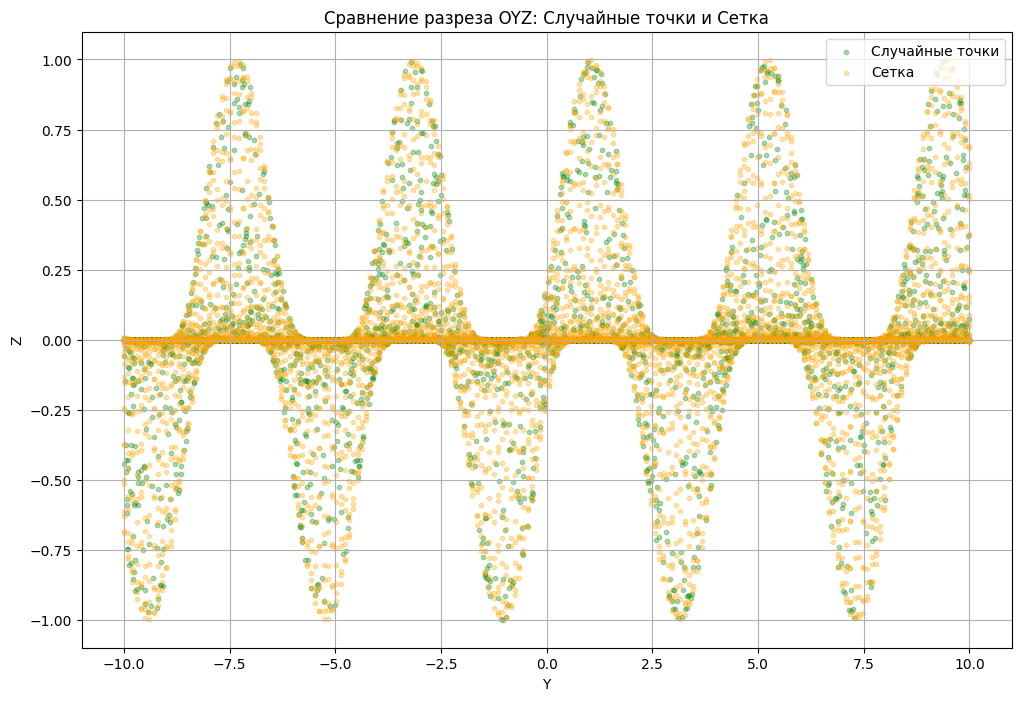

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Сраним их с сеткой которая полуается при помощи Linaspace

# 1. Генерация случайных точек
x_random = np.random.uniform(-10, 10, 20000)
y_random = np.random.uniform(-10, 10, 20000)
z_random = np.sin(x_random + 2 * y_random) * np.exp(-(2 * x_random + y_random) ** 2)

# 2. Генерация точек на сетке
x_grid = np.linspace(-10, 10, 200)
y_grid = np.linspace(-10, 10, 200)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
z_mesh = np.sin(x_mesh + 2 * y_mesh) * np.exp(-(2 * x_mesh + y_mesh) ** 2)

# Преобразуем сетку в одномерные массивы для сравнения
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
z_flat = z_mesh.flatten()

# 3. График OXZ: случайные точки + сетка
plt.figure(figsize=(12, 8))
# Случайные точки
plt.scatter(x_random, z_random, color='blue', alpha=0.3, label="Случайные точки", s=10)
# Сетка
plt.scatter(x_flat, z_flat, color='red', alpha=0.3, label="Сетка", s=10)
plt.title("Сравнение разреза OXZ: Случайные точки и Сетка")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()

# 4. График OYZ: случайные точки + сетка
plt.figure(figsize=(12, 8))
# Случайные точки
plt.scatter(y_random, z_random, color='green', alpha=0.3, label="Случайные точки", s=10)
# Сетка
plt.scatter(y_flat, z_flat, color='orange', alpha=0.3, label="Сетка", s=10)
plt.title("Сравнение разреза OYZ: Случайные точки и Сетка")
plt.xlabel("Y")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()


Видно что мы двигаемся в верном нарпавлении

In [10]:
dataset = My_Func_dataset(x_min=-10, x_max=10, y_min=-10, y_max=10, count=20000)
dataset

In [11]:
# Определяем размеры выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [12]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [13]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Для начала возьмем архитектуру из 3ех слоев и попробуем обучить модель

In [14]:
class my_model(nn.Module):
    def __init__(self, input=2, output=1):
        super(my_model, self).__init__()
        self.linear_1 = nn.Linear(input, 256)
        self.linear_2 = nn.Linear(256, 512)
        self.linear_3 = nn.Linear(512, 256)
        self.linear_4 = nn.Linear(256, output)
        self.active = nn.ReLU()


    def forward(self, x):
        x = self.active(self.linear_1(x))
        x = self.active(self.linear_2(x))
        x = self.active(self.linear_3(x))
        x = self.linear_4(x)
        return x

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
model = my_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
epochs = 300
for epoch in range(epochs):
    model.train()
    train_loss = 0
    test_loss = 0
    for inputs, targets in tqdm(train_loader):

        # Отправляем данные на устройство
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Прямой проход
        output = model(inputs)

        # Вычисление ошибки
        loss = criterion(output.squeeze(), targets)
        train_loss += loss.item()

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(train_loader.dataset)

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Не забывайте про устройство валидации
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


100%|██████████| 219/219 [00:01<00:00, 155.30it/s]


Epoch 1/300, Train Loss: 0.0004, Val Loss: 0.0003


100%|██████████| 219/219 [00:00<00:00, 374.42it/s]


Epoch 2/300, Train Loss: 0.0003, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 363.47it/s]


Epoch 3/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 386.17it/s]


Epoch 4/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 279.23it/s]


Epoch 5/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 272.57it/s]


Epoch 6/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 254.61it/s]


Epoch 7/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 365.22it/s]


Epoch 8/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 371.25it/s]


Epoch 9/300, Train Loss: 0.0002, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 372.94it/s]


Epoch 10/300, Train Loss: 0.0002, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 370.94it/s]


Epoch 11/300, Train Loss: 0.0002, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 368.59it/s]


Epoch 12/300, Train Loss: 0.0002, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 366.48it/s]


Epoch 13/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 368.07it/s]


Epoch 14/300, Train Loss: 0.0002, Val Loss: 0.0002


100%|██████████| 219/219 [00:00<00:00, 384.00it/s]


Epoch 15/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 376.86it/s]


Epoch 16/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 378.76it/s]


Epoch 17/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 388.53it/s]


Epoch 18/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 360.88it/s]


Epoch 19/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 382.49it/s]


Epoch 20/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 386.92it/s]


Epoch 21/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 364.96it/s]


Epoch 22/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 241.83it/s]


Epoch 23/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 256.26it/s]


Epoch 24/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:01<00:00, 159.41it/s]


Epoch 25/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 376.25it/s]


Epoch 26/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 365.47it/s]


Epoch 27/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 386.38it/s]


Epoch 28/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 364.17it/s]


Epoch 29/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 390.98it/s]


Epoch 30/300, Train Loss: 0.0001, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 380.22it/s]


Epoch 31/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.18it/s]


Epoch 32/300, Train Loss: 0.0001, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 393.00it/s]


Epoch 33/300, Train Loss: 0.0001, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 358.55it/s]


Epoch 34/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.31it/s]


Epoch 35/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.01it/s]


Epoch 36/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 376.54it/s]


Epoch 37/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 374.52it/s]


Epoch 38/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 386.02it/s]


Epoch 39/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 371.02it/s]


Epoch 40/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 271.91it/s]


Epoch 41/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 284.45it/s]


Epoch 42/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 257.64it/s]


Epoch 43/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 329.63it/s]


Epoch 44/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 376.32it/s]


Epoch 45/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 365.66it/s]


Epoch 46/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 365.61it/s]


Epoch 47/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.14it/s]


Epoch 48/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.91it/s]


Epoch 49/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.51it/s]


Epoch 50/300, Train Loss: 0.0000, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 379.04it/s]


Epoch 51/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.29it/s]


Epoch 52/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 381.41it/s]


Epoch 53/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 378.52it/s]


Epoch 54/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 379.42it/s]


Epoch 55/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 381.55it/s]


Epoch 56/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 375.93it/s]


Epoch 57/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.94it/s]


Epoch 58/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 318.27it/s]


Epoch 59/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 289.42it/s]


Epoch 60/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 267.27it/s]


Epoch 61/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 287.68it/s]


Epoch 62/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.14it/s]


Epoch 63/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 383.01it/s]


Epoch 64/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 379.16it/s]


Epoch 65/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.33it/s]


Epoch 66/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.98it/s]


Epoch 67/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 385.82it/s]


Epoch 68/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 375.30it/s]


Epoch 69/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.20it/s]


Epoch 70/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 379.95it/s]


Epoch 71/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 374.95it/s]


Epoch 72/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 388.94it/s]


Epoch 73/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.17it/s]


Epoch 74/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.32it/s]


Epoch 75/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 379.32it/s]


Epoch 76/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 330.22it/s]


Epoch 77/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 284.58it/s]


Epoch 78/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 277.54it/s]


Epoch 79/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 265.67it/s]


Epoch 80/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 366.72it/s]


Epoch 81/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 378.20it/s]


Epoch 82/300, Train Loss: 0.0000, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 369.69it/s]


Epoch 83/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 380.14it/s]


Epoch 84/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 246.40it/s]


Epoch 85/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 375.72it/s]


Epoch 86/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.41it/s]


Epoch 87/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 375.54it/s]


Epoch 88/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 374.36it/s]


Epoch 89/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 379.52it/s]


Epoch 90/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 367.97it/s]


Epoch 91/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.71it/s]


Epoch 92/300, Train Loss: 0.0000, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 360.73it/s]


Epoch 93/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.67it/s]


Epoch 94/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 325.38it/s]


Epoch 95/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 278.12it/s]


Epoch 96/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 260.83it/s]


Epoch 97/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 271.88it/s]


Epoch 98/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 371.77it/s]


Epoch 99/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 382.98it/s]


Epoch 100/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.64it/s]


Epoch 101/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.97it/s]


Epoch 102/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 390.54it/s]


Epoch 103/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.44it/s]


Epoch 104/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 359.00it/s]


Epoch 105/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.05it/s]


Epoch 106/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.64it/s]


Epoch 107/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 361.17it/s]


Epoch 108/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 375.49it/s]


Epoch 109/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.75it/s]


Epoch 110/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 366.22it/s]


Epoch 111/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 381.73it/s]


Epoch 112/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 339.20it/s]


Epoch 113/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 281.06it/s]


Epoch 114/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 261.97it/s]


Epoch 115/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 267.42it/s]


Epoch 116/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 383.15it/s]


Epoch 117/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 366.91it/s]


Epoch 118/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 336.05it/s]


Epoch 119/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.78it/s]


Epoch 120/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.61it/s]


Epoch 121/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.03it/s]


Epoch 122/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 382.97it/s]


Epoch 123/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 365.93it/s]


Epoch 124/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 220.23it/s]


Epoch 125/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 284.26it/s]


Epoch 126/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 339.55it/s]


Epoch 127/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.03it/s]


Epoch 128/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 354.57it/s]


Epoch 129/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 279.34it/s]


Epoch 130/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 237.66it/s]


Epoch 131/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:01<00:00, 143.83it/s]


Epoch 132/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:01<00:00, 196.72it/s]


Epoch 133/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 307.39it/s]


Epoch 134/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 347.11it/s]


Epoch 135/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 359.65it/s]


Epoch 136/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 329.22it/s]


Epoch 137/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 374.11it/s]


Epoch 138/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 307.23it/s]


Epoch 139/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 231.75it/s]


Epoch 140/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 244.14it/s]


Epoch 141/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 273.79it/s]


Epoch 142/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.52it/s]


Epoch 143/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 242.55it/s]


Epoch 144/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 272.82it/s]


Epoch 145/300, Train Loss: 0.0000, Val Loss: 0.0001


100%|██████████| 219/219 [00:01<00:00, 187.26it/s]


Epoch 146/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 332.81it/s]


Epoch 147/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 355.99it/s]


Epoch 148/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 265.45it/s]


Epoch 149/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 264.97it/s]


Epoch 150/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 387.00it/s]


Epoch 151/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 360.24it/s]


Epoch 152/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.37it/s]


Epoch 153/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 365.21it/s]


Epoch 154/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.13it/s]


Epoch 155/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.04it/s]


Epoch 156/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 384.31it/s]


Epoch 157/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.71it/s]


Epoch 158/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 350.40it/s]


Epoch 159/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 367.59it/s]


Epoch 160/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 303.36it/s]


Epoch 161/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 286.35it/s]


Epoch 162/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 261.58it/s]


Epoch 163/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 295.64it/s]


Epoch 164/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 376.51it/s]


Epoch 165/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 371.90it/s]


Epoch 166/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 362.85it/s]


Epoch 167/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 366.44it/s]


Epoch 168/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 355.10it/s]


Epoch 169/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.11it/s]


Epoch 170/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 388.98it/s]


Epoch 171/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 382.08it/s]


Epoch 172/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 371.80it/s]


Epoch 173/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.95it/s]


Epoch 174/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 367.38it/s]


Epoch 175/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.90it/s]


Epoch 176/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.64it/s]


Epoch 177/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 362.28it/s]


Epoch 178/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 285.76it/s]


Epoch 179/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 273.72it/s]


Epoch 180/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 253.06it/s]


Epoch 181/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 322.95it/s]


Epoch 182/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 356.62it/s]


Epoch 183/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 358.75it/s]


Epoch 184/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 341.33it/s]


Epoch 185/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 342.64it/s]


Epoch 186/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 372.65it/s]


Epoch 187/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 361.18it/s]


Epoch 188/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 356.60it/s]


Epoch 189/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 380.53it/s]


Epoch 190/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 362.71it/s]


Epoch 191/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.89it/s]


Epoch 192/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 386.75it/s]


Epoch 193/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 358.57it/s]


Epoch 194/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.54it/s]


Epoch 195/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.93it/s]


Epoch 196/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 277.56it/s]


Epoch 197/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 271.80it/s]


Epoch 198/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 257.58it/s]


Epoch 199/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 339.04it/s]


Epoch 200/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.03it/s]


Epoch 201/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.21it/s]


Epoch 202/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.51it/s]


Epoch 203/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 376.69it/s]


Epoch 204/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.25it/s]


Epoch 205/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.25it/s]


Epoch 206/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 382.94it/s]


Epoch 207/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.38it/s]


Epoch 208/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 367.22it/s]


Epoch 209/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 378.54it/s]


Epoch 210/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.46it/s]


Epoch 211/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.27it/s]


Epoch 212/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 378.98it/s]


Epoch 213/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 369.12it/s]


Epoch 214/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 282.15it/s]


Epoch 215/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 284.79it/s]


Epoch 216/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 246.58it/s]


Epoch 217/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 299.61it/s]


Epoch 218/300, Train Loss: 0.0000, Val Loss: 0.0001


100%|██████████| 219/219 [00:00<00:00, 370.12it/s]


Epoch 219/300, Train Loss: 0.0001, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 361.36it/s]


Epoch 220/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.52it/s]


Epoch 221/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 361.43it/s]


Epoch 222/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 353.87it/s]


Epoch 223/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.71it/s]


Epoch 224/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 379.16it/s]


Epoch 225/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.99it/s]


Epoch 226/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.88it/s]


Epoch 227/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.58it/s]


Epoch 228/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 366.79it/s]


Epoch 229/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 349.91it/s]


Epoch 230/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.72it/s]


Epoch 231/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 374.43it/s]


Epoch 232/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 277.38it/s]


Epoch 233/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 275.74it/s]


Epoch 234/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 257.82it/s]


Epoch 235/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 296.94it/s]


Epoch 236/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 373.94it/s]


Epoch 237/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 341.00it/s]


Epoch 238/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 343.71it/s]


Epoch 239/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 356.63it/s]


Epoch 240/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 340.11it/s]


Epoch 241/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 356.96it/s]


Epoch 242/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 383.76it/s]


Epoch 243/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 361.31it/s]


Epoch 244/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 361.62it/s]


Epoch 245/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.39it/s]


Epoch 246/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.15it/s]


Epoch 247/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 358.41it/s]


Epoch 248/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 371.60it/s]


Epoch 249/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 371.92it/s]


Epoch 250/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 280.04it/s]


Epoch 251/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 285.65it/s]


Epoch 252/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 254.84it/s]


Epoch 253/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 280.27it/s]


Epoch 254/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.53it/s]


Epoch 255/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.03it/s]


Epoch 256/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 354.07it/s]


Epoch 257/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 354.51it/s]


Epoch 258/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 357.58it/s]


Epoch 259/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 348.79it/s]


Epoch 260/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 347.32it/s]


Epoch 261/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 352.27it/s]


Epoch 262/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.31it/s]


Epoch 263/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 355.22it/s]


Epoch 264/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 362.79it/s]


Epoch 265/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 354.99it/s]


Epoch 266/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 356.45it/s]


Epoch 267/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.13it/s]


Epoch 268/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 280.55it/s]


Epoch 269/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 286.57it/s]


Epoch 270/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 254.90it/s]


Epoch 271/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 278.57it/s]


Epoch 272/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 291.94it/s]


Epoch 273/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 323.76it/s]


Epoch 274/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 381.28it/s]


Epoch 275/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 364.57it/s]


Epoch 276/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 360.84it/s]


Epoch 277/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 377.56it/s]


Epoch 278/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 345.34it/s]


Epoch 279/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 358.71it/s]


Epoch 280/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 383.53it/s]


Epoch 281/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 353.60it/s]


Epoch 282/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 353.01it/s]


Epoch 283/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 378.20it/s]


Epoch 284/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 366.10it/s]


Epoch 285/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 336.04it/s]


Epoch 286/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 274.66it/s]


Epoch 287/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 287.39it/s]


Epoch 288/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 261.73it/s]


Epoch 289/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 363.36it/s]


Epoch 290/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 347.43it/s]


Epoch 291/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 378.98it/s]


Epoch 292/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.14it/s]


Epoch 293/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 360.75it/s]


Epoch 294/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 365.34it/s]


Epoch 295/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.74it/s]


Epoch 296/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 356.47it/s]


Epoch 297/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 370.20it/s]


Epoch 298/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 368.99it/s]


Epoch 299/300, Train Loss: 0.0000, Val Loss: 0.0000


100%|██████████| 219/219 [00:00<00:00, 352.30it/s]

Epoch 300/300, Train Loss: 0.0000, Val Loss: 0.0000


In [19]:
# Шаг 5: Тестирование модели
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss:.4f}")
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0138
Test Loss: 0.0000


In [20]:
randmy= np.sin(1 + 1 * 1) * np.exp(-(1 * 2 + 1) ** 2)
randmy

0.00011221621730107923

In [21]:
model.eval()
with torch.no_grad():
    input_data = torch.tensor([1, 1], dtype=torch.float32).to(device)  # Переносим входные данные на устройство
    print(model(input_data).item())

-0.0001313725224463269


Для построения решения объеденим датасет и построим массивы на основе предсказаний

In [22]:
# Объединение всех датасетов в один
full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# Создание одного DataLoader для всех данных
full_loader = DataLoader(full_dataset, batch_size=batch_size)

In [23]:
model.eval()  # Устанавливаем модель в режим оценки (выключаем dropout и т.п.)
x, y, z, z_true = list(), list(), list(), list()  # Инициализируем списки для хранения данных

# Отключаем градиенты, так как они не нужны при оценке
with torch.no_grad():
    for inputs, targets in full_loader:  # Перебор всех батчей в full_loader
        inputs = inputs.to(device)  # Переносим данные на нужное устройство
        targets = targets.to(device)  # Переносим цели на устройство
        outputs = model(inputs)  # Получаем выходы модели

        # Добавляем все данные в списки
        x.append(inputs[:, 0].cpu())  # Добавляем все элементы первой особенности
        y.append(inputs[:, 1].cpu())  # Добавляем все элементы второй особенности
        z.append(outputs.cpu())
        z_true.append(targets.cpu())        # Добавляем выходы модели для всего батча

# Преобразуем списки в тензоры, если нужно
x = torch.cat(x).numpy()  # Конкатенируем все элементы для x
y = torch.cat(y).numpy()  # Конкатенируем все элементы для y
z = torch.cat(z).flatten().numpy()  # Конкатенируем все элементы для z
z_true = torch.cat(z_true).numpy()

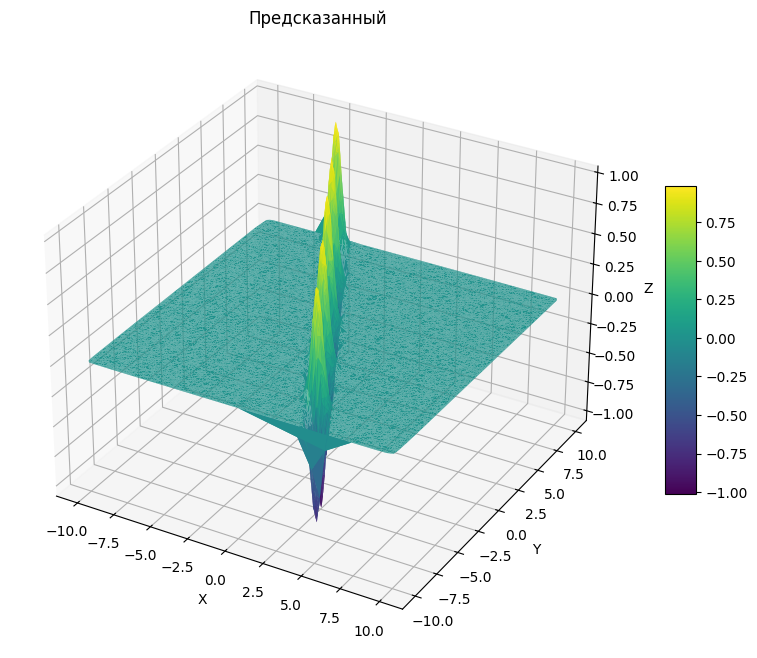

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Предсказанный")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
# Рассчитываем MSE
mse = mean_squared_error(z_true, z)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0002667275839485228


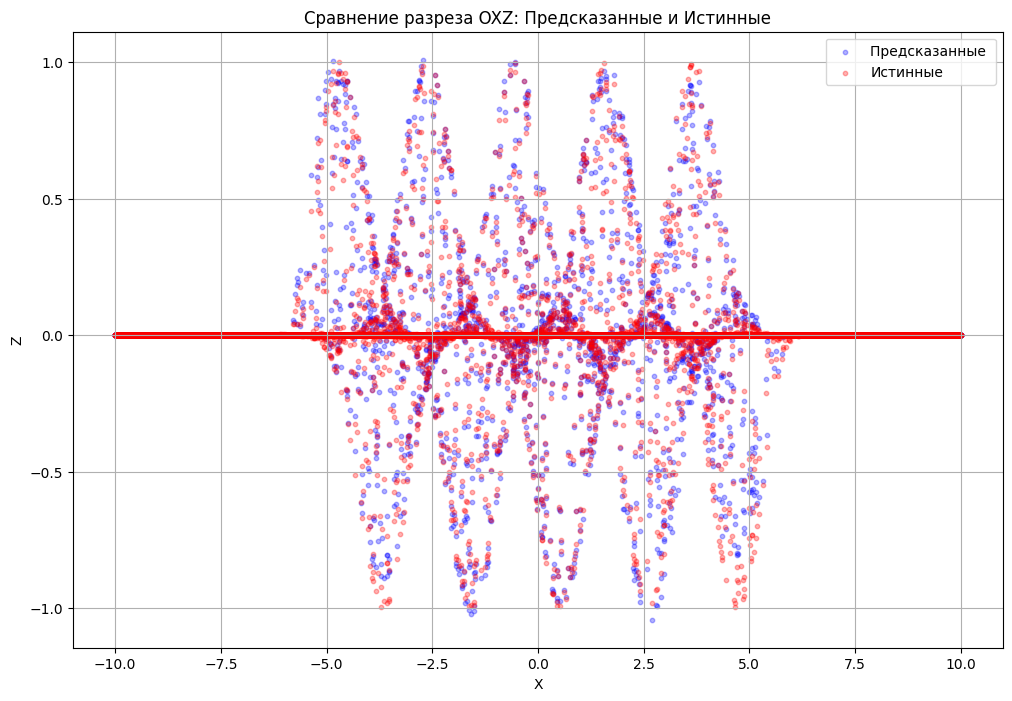

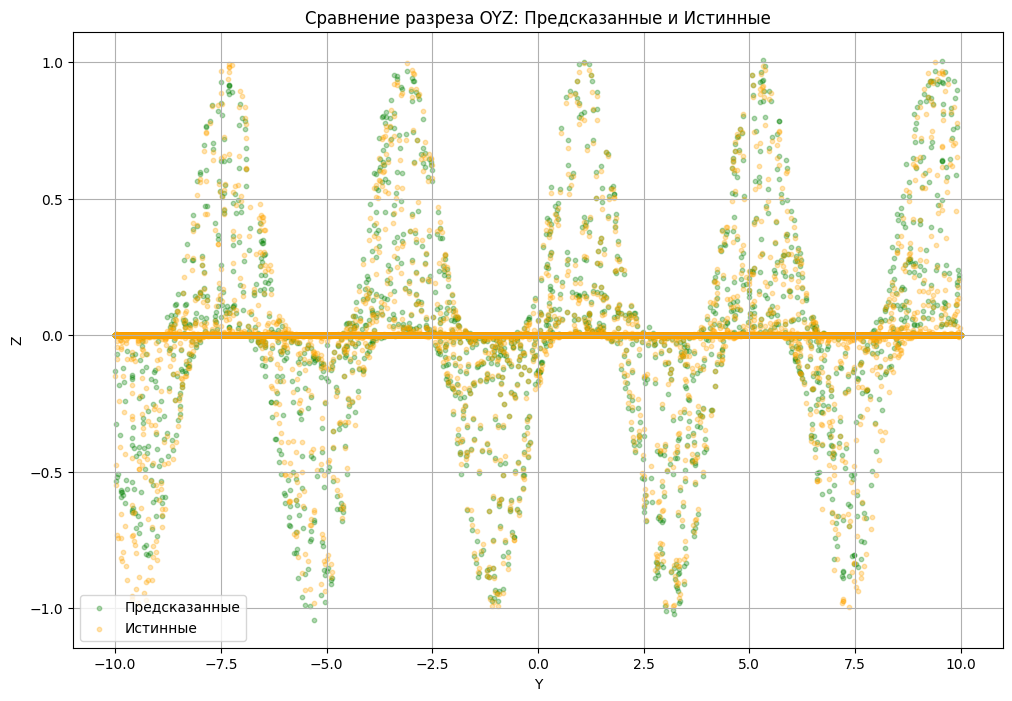

In [26]:
import matplotlib.pyplot as plt
import numpy as np


# Преобразуем сетку в одномерные массивы для сравнения

# 3. График OXZ: случайные точки + сетка
plt.figure(figsize=(12, 8))
# Случайные точки
plt.scatter(x, z, color='blue', alpha=0.3, label="Предсказанные ", s=10)
# Сетка
plt.scatter(x, z_true, color='red', alpha=0.3, label="Истинные", s=10)
plt.title("Сравнение разреза OXZ: Предсказанные и Истинные")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()

# 4. График OYZ: случайные точки + сетка
plt.figure(figsize=(12, 8))
# Случайные точки
plt.scatter(y, z, color='green', alpha=0.3, label="Предсказанные", s=10)
# Сетка
plt.scatter(y, z_true, color='orange', alpha=0.3, label="Истинные", s=10)
plt.title("Сравнение разреза OYZ: Предсказанные и Истинные")
plt.xlabel("Y")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()


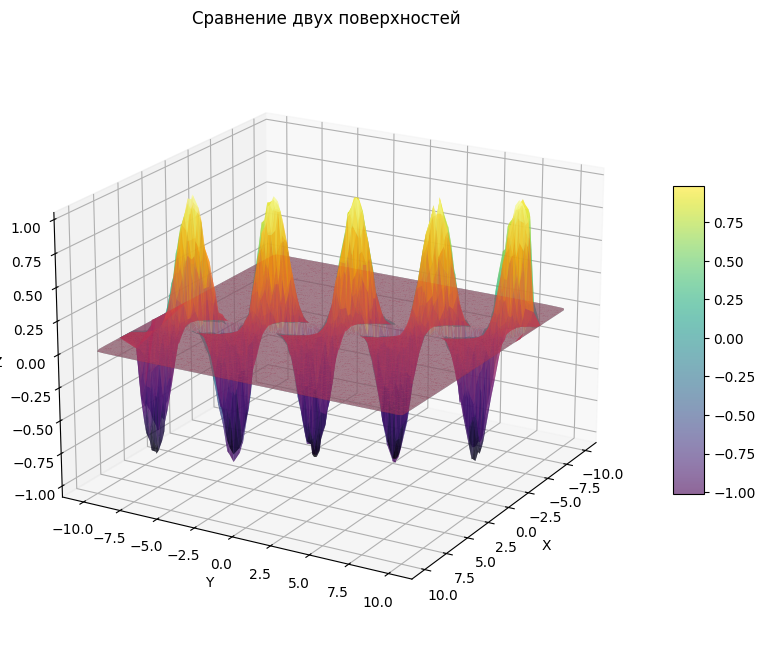

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Пример данных (замените на свои данные)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Первая поверхность
surf1 = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none', alpha=0.6)

# Вторая поверхность
surf2 = ax.plot_trisurf(x, y, z_true, cmap='inferno', edgecolor='none', alpha=0.6)

# Добавляем цветовую шкалу
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10)

# Подписи и заголовки
ax.set_title("Сравнение двух поверхностей")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.ion()
ax.view_init(elev=20., azim=30)
# Показываем график
plt.show()


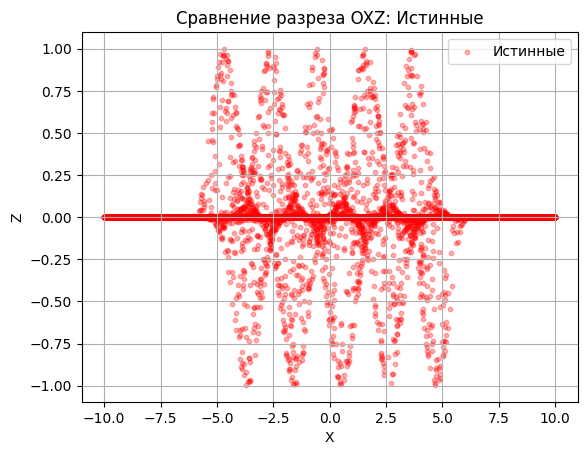

In [29]:
plt.scatter(x, z_true, color='red', alpha=0.3, label="Истинные", s=10)
plt.title("Сравнение разреза OXZ: Истинные")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()

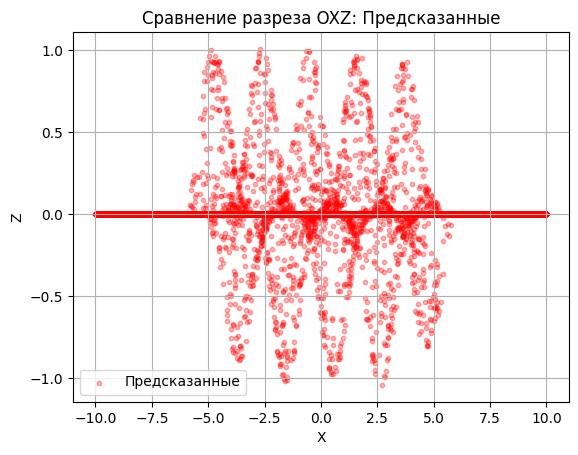

In [30]:
plt.scatter(x, z, color='red', alpha=0.3, label="Предсказанные", s=10)
plt.title("Сравнение разреза OXZ: Предсказанные")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid()
plt.show()

Видно, что модель достаточно точно выучил зависимость, хоть и не идеально